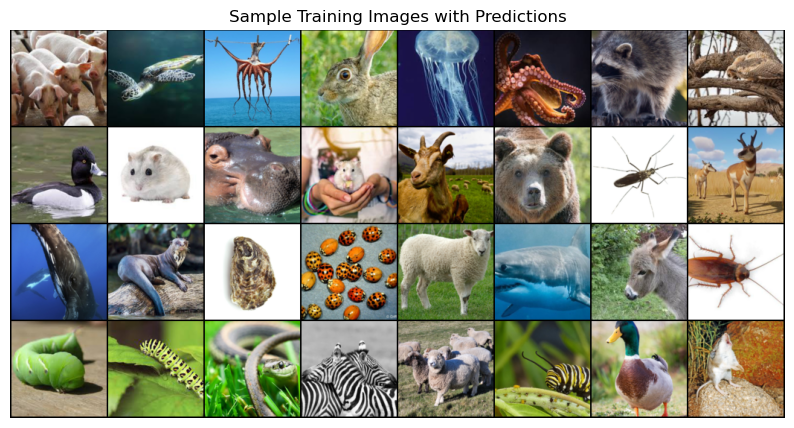

True: pig, Predicted: pig
True: turtle, Predicted: leopard
True: octopus, Predicted: octopus
True: hare, Predicted: hare
True: jellyfish, Predicted: jellyfish
True: octopus, Predicted: octopus
True: raccoon, Predicted: raccoon
True: owl, Predicted: owl
True: duck, Predicted: duck
True: hamster, Predicted: hamster


In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

IMPORTING REQUIRED LIBRARIES

In [2]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import shutil
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report
from PIL import Image
from pytorch_fid import fid_score

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) 

Random Seed:  999


Select 20 subclasses

In [ ]:
#randimly selected 20 subclasses out of 90 classes
# total datapoints now =1200 , 60 images per class
base_dir = '/data1/Code/Nidhi/ADRLAss1/animals' 
selected_folder = '/data1/Code/Nidhi/ADRLAss1/selected_data'
num_classes = 20
batch_size = 32
epochs = 20
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
checkpoint_path= '/data1/Code/Nidhi/ADRLAss1/best_model_resnet.pth'
image_size = 228

subfolders = [f.path for f in os.scandir(base_dir) if f.is_dir()]
selected_subfolders = random.sample(subfolders, num_classes)
print("Selected Subfolders:")
print(selected_subfolders)

if not os.path.exists(selected_folder):
    os.makedirs(selected_folder)

label_to_animal = {}

for label, folder in enumerate(selected_subfolders):
    animal_name = os.path.basename(folder)  
    label_folder = os.path.join(selected_folder, str(label).zfill(2)) 
    os.makedirs(label_folder, exist_ok=True)
    label_to_animal[label] = animal_name
    
    for item in os.listdir(folder):
        s = os.path.join(folder, item)
        d = os.path.join(label_folder, item)
        if os.path.isdir(s):
            shutil.copytree(s, d)  
        else:
            shutil.copy2(s, d)  
print("Label to Animal Mapping:")
for label, animal in label_to_animal.items():
    print(f'Label {label}: {animal}')

train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = datasets.ImageFolder(root=selected_folder, transform=train_transform)
print(dataset)


Selected Subfolders:
['/data1/Code/Nidhi/ADRLAss1/animals/orangutan', '/data1/Code/Nidhi/ADRLAss1/animals/seahorse', '/data1/Code/Nidhi/ADRLAss1/animals/squirrel', '/data1/Code/Nidhi/ADRLAss1/animals/starfish', '/data1/Code/Nidhi/ADRLAss1/animals/cow', '/data1/Code/Nidhi/ADRLAss1/animals/reindeer', '/data1/Code/Nidhi/ADRLAss1/animals/penguin', '/data1/Code/Nidhi/ADRLAss1/animals/crab', '/data1/Code/Nidhi/ADRLAss1/animals/pig', '/data1/Code/Nidhi/ADRLAss1/animals/gorilla', '/data1/Code/Nidhi/ADRLAss1/animals/shark', '/data1/Code/Nidhi/ADRLAss1/animals/goose', '/data1/Code/Nidhi/ADRLAss1/animals/hippopotamus', '/data1/Code/Nidhi/ADRLAss1/animals/zebra', '/data1/Code/Nidhi/ADRLAss1/animals/elephant', '/data1/Code/Nidhi/ADRLAss1/animals/oyster', '/data1/Code/Nidhi/ADRLAss1/animals/hedgehog', '/data1/Code/Nidhi/ADRLAss1/animals/woodpecker', '/data1/Code/Nidhi/ADRLAss1/animals/deer', '/data1/Code/Nidhi/ADRLAss1/animals/pigeon']
Label to Animal Mapping:
Label 0: orangutan
Label 1: seahorse
Label 2: squirrel
Label 3: starfish
Label 4: cow
Label 5: reindeer
Label 6: penguin
Label 7: crab
Label 8: pig
Label 9: gorilla
Label 10: shark
Label 11: goose
Label 12: hippopotamus
Label 13: zebra
Label 14: elephant
Label 15: oyster
Label 16: hedgehog
Label 17: woodpecker
Label 18: deer
Label 19: pigeon
Dataset ImageFolder
    Number of datapoints: 1200
    Root location: /data1/Code/Nidhi/ADRLAss1/selected_data
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


TRAIN, TEST, VALIDATION SPLIT

In [ ]:
#splitting dataset into train(70%), validation (15%)and test set(15%) based on stratified sampling so that each class data is present in equal proportion in each set
train_size = int(0.7 * len(dataset)) 
val_size = int(0.15 * len(dataset))    
test_size = len(dataset) - train_size - val_size  

label_to_indices = {}
for idx, (_, label) in enumerate(dataset.samples):
    if label not in label_to_indices:
        label_to_indices[label] = []
    label_to_indices[label].append(idx)

train_indices = []
val_indices = []
test_indices = []

for label, indices in label_to_indices.items():
    np.random.shuffle(indices)  
    n_samples = len(indices)
    n_train = int(train_size * n_samples / len(dataset))
    n_val = int(val_size * n_samples / len(dataset))
    
    train_indices.extend(indices[:n_train])
    val_indices.extend(indices[n_train:n_train + n_val])
    test_indices.extend(indices[n_train + n_val:n_samples])

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def print_class_distribution(dataset, original_dataset, name):
    labels = [original_dataset.targets[idx] for idx in dataset.indices] 
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(f"Class distribution in {name}: {distribution}")

print_class_distribution(train_dataset, dataset, "Training set")
print_class_distribution(val_dataset, dataset, "Validation set")
print_class_distribution(test_dataset, dataset, "Test set")


Class distribution in Training set: {0: 42, 1: 42, 2: 42, 3: 42, 4: 42, 5: 42, 6: 42, 7: 42, 8: 42, 9: 42, 10: 42, 11: 42, 12: 42, 13: 42, 14: 42, 15: 42, 16: 42, 17: 42, 18: 42, 19: 42}
Class distribution in Validation set: {0: 9, 1: 9, 2: 9, 3: 9, 4: 9, 5: 9, 6: 9, 7: 9, 8: 9, 9: 9, 10: 9, 11: 9, 12: 9, 13: 9, 14: 9, 15: 9, 16: 9, 17: 9, 18: 9, 19: 9}
Class distribution in Test set: {0: 9, 1: 9, 2: 9, 3: 9, 4: 9, 5: 9, 6: 9, 7: 9, 8: 9, 9: 9, 10: 9, 11: 9, 12: 9, 13: 9, 14: 9, 15: 9, 16: 9, 17: 9, 18: 9, 19: 9}


Training pretrained resnet50 on 20 subclasses

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
#training
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

#validation  
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    #saving best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print("Best model saved.")

model.load_state_dict(torch.load(checkpoint_path))

# testing
def evaluate(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device, labels.to(device))
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return all_labels, all_preds

test_labels, test_preds = evaluate(model, test_loader)
print("Test Metrics:")
print(classification_report(test_labels, test_preds))

Epoch [1/20], Train Loss: 7.6453, Val Loss: 8.4560, Val Accuracy: 0.2556
Best model saved.
Epoch [2/20], Train Loss: 4.1833, Val Loss: 2.8817, Val Accuracy: 0.3778
Best model saved.
Epoch [3/20], Train Loss: 3.2055, Val Loss: 2.5432, Val Accuracy: 0.4500
Best model saved.
Epoch [4/20], Train Loss: 2.9690, Val Loss: 3.7649, Val Accuracy: 0.3333
Epoch [5/20], Train Loss: 2.3178, Val Loss: 2.0222, Val Accuracy: 0.5167
Best model saved.
Epoch [6/20], Train Loss: 1.9944, Val Loss: 1.6834, Val Accuracy: 0.5500
Best model saved.
Epoch [7/20], Train Loss: 1.7199, Val Loss: 1.6135, Val Accuracy: 0.6333
Best model saved.
Epoch [8/20], Train Loss: 3.2268, Val Loss: 2.1392, Val Accuracy: 0.5556
Epoch [9/20], Train Loss: 0.9382, Val Loss: 1.5199, Val Accuracy: 0.6056
Best model saved.
Epoch [10/20], Train Loss: 1.3205, Val Loss: 1.5877, Val Accuracy: 0.6167
Epoch [11/20], Train Loss: 2.0560, Val Loss: 1.4368, Val Accuracy: 0.6556
Best model saved.
Epoch [12/20], Train Loss: 3.4265, Val Loss: 2.1996, Val Accuracy: 0.5778
Epoch [13/20], Train Loss: 0.9885, Val Loss: 2.2422, Val Accuracy: 0.5333
Epoch [14/20], Train Loss: 2.8450, Val Loss: 2.5949, Val Accuracy: 0.5111
Epoch [15/20], Train Loss: 1.4778, Val Loss: 1.3500, Val Accuracy: 0.6833
Best model saved.
Epoch [16/20], Train Loss: 2.2767, Val Loss: 2.0494, Val Accuracy: 0.6000
Epoch [17/20], Train Loss: 1.5430, Val Loss: 1.5312, Val Accuracy: 0.5778
Epoch [18/20], Train Loss: 1.9048, Val Loss: 2.0332, Val Accuracy: 0.5556
Epoch [19/20], Train Loss: 0.9091, Val Loss: 1.8209, Val Accuracy: 0.5778
Epoch [20/20], Train Loss: 1.8279, Val Loss: 1.3464, Val Accuracy: 0.7056
Best model saved.
Test Metrics:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.73      0.89      0.80         9
           2       0.75      0.67      0.71         9
           3       0.73      0.89      0.80         9
           4       0.43      0.67      0.52         9
           5       1.00      0.89      0.94         9
           6       0.75      0.33      0.46         9
           7       0.50      0.67      0.57         9
           8       1.00      0.44      0.62         9
           9       0.71      0.56      0.63         9
          10       0.60      0.67      0.63         9
          11       0.47      0.78      0.58         9
          12       0.89      0.89      0.89         9
          13       1.00      0.78      0.88         9
          14       0.80      0.89      0.84         9
          15       0.64      1.00      0.78         9
          16       1.00      1.00      1.00         9
          17       1.00      0.89      0.94         9
          18       1.00      0.67      0.80         9
          19       1.00      0.33      0.50         9

    accuracy                           0.73       180
   macro avg       0.78      0.73      0.73       180
weighted avg       0.78      0.73      0.73       180



CGAN

In [ ]:
batch_size = 64
image_size = 128
channels = 3
noise_vector = 128
num_epochs = 200
num_classes = 20
embed_size=128

DATA AUGMENTATION

In [ ]:
#generating 200 more images per class

data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

input_dir = '/data1/Code/Nidhi/ADRLAss1/selected_data'  # CONTAINS 20 SUBCLASSES
output_dir = '/data1/Code/Nidhi/ADRLAss1/augmented_data2'  

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for subfolder in os.listdir(input_dir):
    subfolder_path = os.path.join(input_dir, subfolder)
    output_subfolder = os.path.join(output_dir, subfolder)

    if not os.path.exists(output_subfolder):
        os.makedirs(output_subfolder)
    images = os.listdir(subfolder_path)
    
    num_augmented_images = 200
    
    augmented_count = 0
    while augmented_count < num_augmented_images:
        img_name = random.choice(images)
        img_path = os.path.join(subfolder_path, img_name)
        image = Image.open(img_path)
        augmented_image = data_augmentation(image)
        augmented_img_name = f"{os.path.splitext(img_name)[0]}_aug_{augmented_count}.png"
        augmented_image_pil = transforms.ToPILImage()(augmented_image)
        augmented_image_pil.save(os.path.join(output_subfolder, augmented_img_name))
        augmented_count += 1

Shape of real_batch: torch.Size([64, 3, 128, 128])
Range of grid values: 0.0 1.0


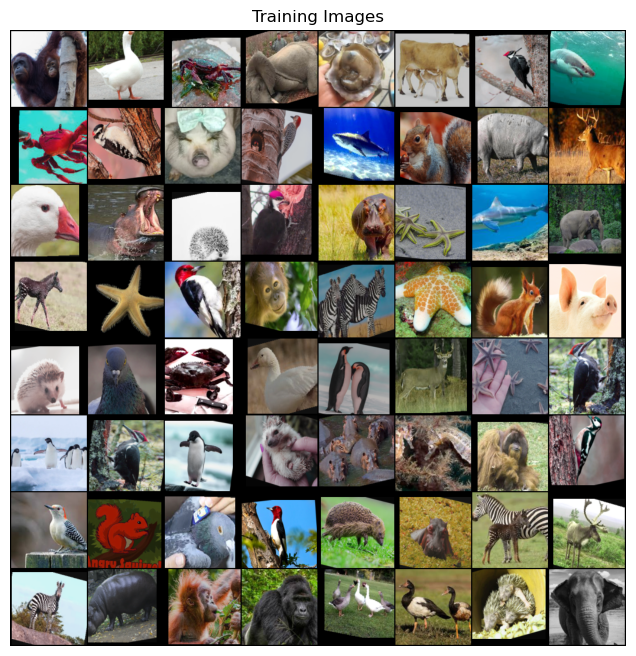

In [ ]:
cgan_training_folder = '/data1/Code/Nidhi/ADRLAss1/augmented_data2'
dataset = dset.ImageFolder(root=cgan_training_folder,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)


real_batch = next(iter(dataloader))
real_batch = real_batch[0].to(device)  
print("Shape of real_batch:", real_batch.shape)
grid = vutils.make_grid(real_batch[:64], padding=2, normalize=True)
grid = grid.cpu()  
grid = np.transpose(grid.numpy(), (1, 2, 0))  
print("Range of grid values:", grid.min(), grid.max())
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(grid)
plt.show()

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, num_classes,image_size,embed_size):
        super(Generator, self).__init__()
        self.image_size=image_size
        self.main = nn.Sequential(
            nn.ConvTranspose2d( noise_vector+embed_size, 64 * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(64 * 16, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d( 64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),            
            
            nn.ConvTranspose2d( 64 * 2, 64 , 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d( 64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.embed =  nn.Embedding(num_classes,embed_size)

    def forward(self, noise, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)  
        input = torch.cat([noise, embedding], dim=1)    #[batch_size, nz + embed_size, 1, 1]
        return self.main(input)

In [7]:
netG = Generator(num_classes,image_size,embed_size).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(256, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

Discriminator Code


In [8]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self,num_classes,image_size):
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.main = nn.Sequential(
            nn.Conv2d(channels+1, 64, 4, 2, 1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64* 4, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),  
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),  
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1, 1, 5, 1, 0, bias=False),  
            nn.Sigmoid()
        )
        self.embed = nn.Embedding(num_classes,image_size*image_size)
    def forward(self, input,labels):
        embedding = self.embed(labels).view(labels.shape[0],1,self.image_size,self.image_size)
        input=torch.cat([input,embedding],dim=1)  #batch_size* number of channel*image_size(H)*image_size(W)
        return self.main(input)


In [9]:
netD = Discriminator(num_classes,image_size).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
  

In [10]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, noise_vector, 1, 1, device=device)
fixed_labels = torch.randint(0, 20, (64,)).to(device)
real_label = 1.
fake_label = 0.
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

CGAN TRAINING

In [ ]:
#saving checkpoints after every 10 epochs 
checkpoint_dir = '/data1/Code/Nidhi/ADRLAss1/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, iters, path):
    state = {
        'epoch': epoch,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
        'iters': iters
    }
    torch.save(state, path)
    print(f'Checkpoint saved at epoch {epoch}, iteration {iters}')


def load_checkpoint(netG, netD, optimizerG, optimizerD, path):
    if os.path.exists(path):
        state = torch.load(path)
        netG.load_state_dict(state['netG_state_dict'])
        netD.load_state_dict(state['netD_state_dict'])
        optimizerG.load_state_dict(state['optimizerG_state_dict'])
        optimizerD.load_state_dict(state['optimizerD_state_dict'])
        epoch = state['epoch']
        G_losses = state['G_losses']
        D_losses = state['D_losses']
        iters = state['iters']
        print(f'Checkpoint loaded from epoch {epoch}, iteration {iters}')
        return epoch, G_losses, D_losses,  iters
    else:
        print('No checkpoint found, starting from scratch.')
        return 0, [], [], 0  

checkpoint_path = '/data1/Code/Nidhi/ADRLAss1/checkpoints/checkpoint_epoch_90.pth' 
start_epoch, G_losses, D_losses, iters = load_checkpoint(netG, netD, optimizerG, optimizerD, checkpoint_path)

# Training 
torch.use_deterministic_algorithms(False)
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")
for epoch in range(start_epoch, num_epochs):
    epoch_G_loss = 0.0
    epoch_D_loss = 0.0
    num_iterations = 0

    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        labels = data[1].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu, labels).view(b_size)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, noise_vector, 1, 1, device=device)
        fake = netG(noise, labels)
        label.fill_(fake_label)
        output = netD(fake.detach(), labels).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        torch.nn.utils.clip_grad_norm_(netD.parameters(), max_norm=1.0)
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake, labels).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        torch.nn.utils.clip_grad_norm_(netG.parameters(), max_norm=1.0)
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        epoch_G_loss += errG.item()
        epoch_D_loss += errD.item()
        num_iterations += 1

    avg_G_loss = epoch_G_loss / num_iterations
    avg_D_loss = epoch_D_loss / num_iterations
    G_losses.append(avg_G_loss)
    D_losses.append(avg_D_loss)

    if epoch % 10 == 0: #SAVING CHECKPOINTS AFTER EVERY 10 EPOCHS
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
        save_checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, iters, checkpoint_path)


/tmp/ipykernel_1321901/1568783205.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path)


Checkpoint loaded from epoch 90, iteration 0
Starting Training Loop...
[90/200][0/82]	Loss_D: 3.2409	Loss_G: 0.3986	D(x): 0.9950	D(G(z)): 0.9263 / 0.7209
[90/200][50/82]	Loss_D: 0.8065	Loss_G: 1.8684	D(x): 0.6690	D(G(z)): 0.1155 / 0.1675
Checkpoint saved at epoch 90, iteration 0
[91/200][0/82]	Loss_D: 1.2380	Loss_G: 3.1581	D(x): 0.7680	D(G(z)): 0.3466 / 0.1030
[91/200][50/82]	Loss_D: 0.5092	Loss_G: 4.6458	D(x): 0.9220	D(G(z)): 0.3025 / 0.0111
[92/200][0/82]	Loss_D: 1.0706	Loss_G: 3.2331	D(x): 0.9188	D(G(z)): 0.5231 / 0.0672
[92/200][50/82]	Loss_D: 0.6837	Loss_G: 2.9491	D(x): 0.9871	D(G(z)): 0.4090 / 0.1043
[93/200][0/82]	Loss_D: 1.1565	Loss_G: 1.8009	D(x): 0.5960	D(G(z)): 0.1769 / 0.2401
[93/200][50/82]	Loss_D: 0.4955	Loss_G: 4.1693	D(x): 0.7931	D(G(z)): 0.0605 / 0.0385
[94/200][0/82]	Loss_D: 0.5192	Loss_G: 2.3546	D(x): 0.7116	D(G(z)): 0.0240 / 0.1756
[94/200][50/82]	Loss_D: 1.4231	Loss_G: 1.3503	D(x): 0.9986	D(G(z)): 0.7123 / 0.3160
[95/200][0/82]	Loss_D: 0.4986	Loss_G: 3.0155	D(x): 0

PLOTTING GENERATOR AND DISCRIMINATOR LOSS

In [ ]:
num_epochs_to_plot = 120
G_losses_to_plot = G_losses[:num_epochs_to_plot]
D_losses_to_plot = D_losses[:num_epochs_to_plot]
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses_to_plot,label="G")
plt.plot(D_losses_to_plot,label="D")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

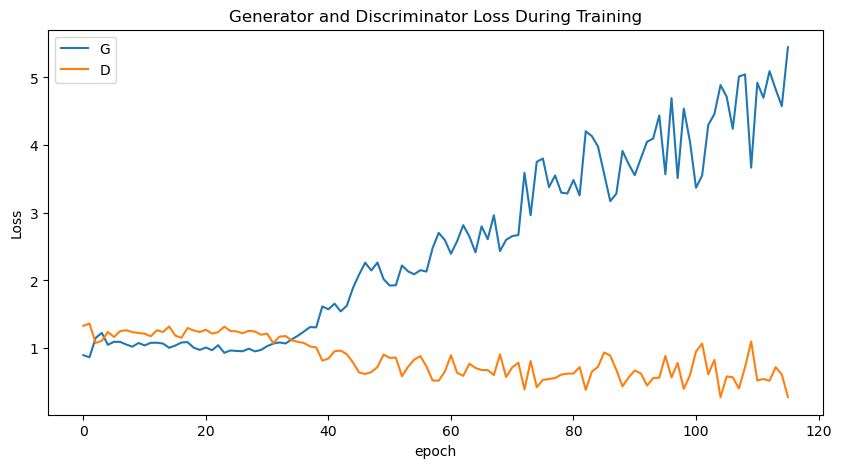

lOADING CHECKPOINTS AND GENERATING FEW IMAGES FOR VISUALIZATION

In [ ]:
checkpoint_path = "/data1/Code/Nidhi/ADRLAss1/checkpoints/checkpoint_epoch_100.pth"
start_epoch, G_losses, D_losses, iters = load_checkpoint(netG, netD, optimizerG, optimizerD , checkpoint_path)

In [27]:
netG.eval()
with torch.no_grad():
    fake_images = netG(fixed_noise, fixed_labels).detach().cpu()


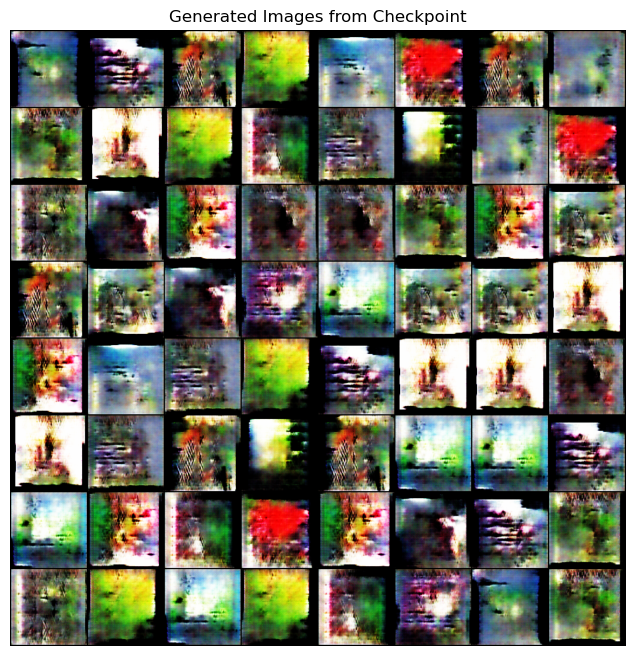

In [28]:
img_grid = vutils.make_grid(fake_images, padding=2, normalize=True)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images from Checkpoint")
plt.imshow(img_grid.permute(1, 2, 0)) 
plt.show()


Generated 100 images for each class

In [29]:
# for each label generating 100 images and saving it in directory
def generate_images(netG, num_images=100, output_dir='/data1/Code/Nidhi/ADRLAss1/generated_images4'):
    os.makedirs(output_dir, exist_ok=True)
    
    for label in range(20): 
        label_dir = os.path.join(output_dir, f'label_{label}')
        os.makedirs(label_dir, exist_ok=True)

        for i in range(num_images):
            noise = torch.randn(1, noise_vector, 1, 1, device=device)  
            current_label = torch.tensor([label], device=device)  

            with torch.no_grad():
                fake_image = netG(noise, current_label).detach().cpu()  

            save_path = os.path.join(label_dir, f'image_{i + 1}.png')
            vutils.save_image(fake_image, save_path, normalize=True)
            print(f'Saved image to {save_path}')

start_epoch, G_losses, D_losses, iters = load_checkpoint(netG, netD, optimizerG, optimizerD, checkpoint_path)
generate_images(netG, num_images=100)

/tmp/ipykernel_1300814/3718434042.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path)


Checkpoint loaded from epoch 99, iteration 8200
Saved image to /data1/Code/Nidhi/ADRLAss1/generated_images4/label_0/image_1.png
Saved image to /data1/Code/Nidhi/ADRLAss1/generated_images4/label_0/image_2.png
Saved image to /data1/Code/Nidhi/ADRLAss1/generated_images4/label_0/image_3.png
Saved image to /data1/Code/Nidhi/ADRLAss1/generated_images4/label_0/image_4.png
Saved image to /data1/Code/Nidhi/ADRLAss1/generated_images4/label_0/image_5.png
Saved image to /data1/Code/Nidhi/ADRLAss1/generated_images4/label_0/image_6.png
Saved image to /data1/Code/Nidhi/ADRLAss1/generated_images4/label_0/image_7.png
Saved image to /data1/Code/Nidhi/ADRLAss1/generated_images4/label_0/image_8.png
Saved image to /data1/Code/Nidhi/ADRLAss1/generated_images4/label_0/image_9.png
Saved image to /data1/Code/Nidhi/ADRLAss1/generated_images4/label_0/image_10.png
Saved image to /data1/Code/Nidhi/ADRLAss1/generated_images4/label_0/image_11.png
Saved image to /data1/Code/Nidhi/ADRLAss1/generated_images4/label_0/im

FID CALCULATION

In [ ]:
#calculated fid by taking training images folder and generated images folder for a class
real_images_dir = '/data1/Code/Nidhi/ADRLAss1/augmented_data2/05'
generated_images_dir = '/data1/Code/Nidhi/ADRLAss1/generated_images4/label_5'

real_temp_dir = '/data1/Code/Nidhi/ADRLAss1/temp_real_images'
generated_temp_dir = '/data1/Code/Nidhi/ADRLAss1/temp_generated_images'

target_size = (299, 299)
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor()
])

def collect_images_from_subfolders(directory):
    image_paths = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(subdir, file))
    return image_paths
# SELECTING RANDOMLY 100 IMAGES
def select_images(image_paths, num_images):
    if len(image_paths) < num_images:
        raise ValueError(f"Not enough images. Required: {num_images}, Found: {len(image_paths)}")
    return random.sample(image_paths, num_images)
# SAVING RESIIZED IMAGE TO TEMPORARY DIRECTORY
def save_resized_images(image_paths, target_dir):
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)  
    os.makedirs(target_dir, exist_ok=True)
    for i, img_path in enumerate(image_paths):
        img = Image.open(img_path).convert("RGB")  
        img_resized = img.resize(target_size)
        img_resized.save(os.path.join(target_dir, f"image_{i}.png"))
real_images_paths = collect_images_from_subfolders(real_images_dir)
generated_images_paths = collect_images_from_subfolders(generated_images_dir)
num_real_images = len(real_images_paths)
num_generated_images = len(generated_images_paths)
print(f"Number of real images: {num_real_images}")
print(f"Number of generated images: {num_generated_images}")
num_images= 100
if num_real_images < num_images or num_generated_images < num_images:
    raise ValueError("Not enough images in one or both directories to use 100 images for FID calculation.")

selected_real_images = select_images(real_images_paths, num_images)
selected_generated_images = select_images(generated_images_paths, num_images)

print("Resizing and saving selected images...")
save_resized_images(selected_real_images, real_temp_dir)
save_resized_images(selected_generated_images, generated_temp_dir)

batch_size = min(50, num_images)
print(f"Using batch size: {batch_size}")

fid_value = fid_score.calculate_fid_given_paths(
    [real_temp_dir, generated_temp_dir],
    batch_size=batch_size,
    device='cpu',
    dims=2048
)
shutil.rmtree(real_temp_dir)
shutil.rmtree(generated_temp_dir)
print(f'FID: {fid_value:.4f}')


Number of real images: 260
Number of generated images: 100
Resizing and saving selected images...
Using batch size: 50
100%|██████████| 2/2 [00:04<00:00,  2.25s/it]
100%|██████████| 2/2 [00:05<00:00,  2.57s/it]
FID: 305.4910


Training resnet50 with generated images

In [ ]:
Generated_image_folder = '/data1/Code/Nidhi/ADRLAss1/generated_images4'
batch_size = 32
epochs = 10
checkpoint_path = '/data1/Code/Nidhi/ADRLAss1/best_model_resnetQ12.pth'


train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.ImageFolder(root=Generated_image_folder , transform=train_transform)


TRAIN,TEST,VALIDATION SPLIT

In [ ]:
#splitting dataset into train(70%), validation (15%)and test set(15%) based on stratified sampling so that each class data is present in equal proportion in each set
train_size = int(0.7 * len(dataset))  
val_size = int(0.15 * len(dataset))    
test_size = len(dataset) - train_size - val_size  

#stratified sampling
label_to_indices = {}
for idx, (_, label) in enumerate(dataset.samples):
    if label not in label_to_indices:
        label_to_indices[label] = []
    label_to_indices[label].append(idx)

train_indices = []
val_indices = []
test_indices = []

for label, indices in label_to_indices.items():
    np.random.shuffle(indices)  
    n_samples = len(indices)
    n_train = int(train_size * n_samples / len(dataset))
    n_val = int(val_size * n_samples / len(dataset))
    
    train_indices.extend(indices[:n_train])
    val_indices.extend(indices[n_train:n_train + n_val])
    test_indices.extend(indices[n_train + n_val:n_samples])

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def print_class_distribution(dataset, original_dataset, name):
    labels = [original_dataset.targets[idx] for idx in dataset.indices]  
    unique, counts = np.unique(labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(f"Class distribution in {name}: {distribution}")

print_class_distribution(train_dataset, dataset, "Training set")
print_class_distribution(val_dataset, dataset, "Validation set")
print_class_distribution(test_dataset, dataset, "Test set")


Class distribution in Training set: {0: 70, 1: 70, 2: 70, 3: 70, 4: 70, 5: 70, 6: 70, 7: 70, 8: 70, 9: 70, 10: 70, 11: 70, 12: 70, 13: 70, 14: 70, 15: 70, 16: 70, 17: 70, 18: 70, 19: 70}
Class distribution in Validation set: {0: 15, 1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15, 9: 15, 10: 15, 11: 15, 12: 15, 13: 15, 14: 15, 15: 15, 16: 15, 17: 15, 18: 15, 19: 15}
Class distribution in Test set: {0: 15, 1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15, 9: 15, 10: 15, 11: 15, 12: 15, 13: 15, 14: 15, 15: 15, 16: 15, 17: 15, 18: 15, 19: 15}



TRAINING RESNET 50 ON GENERATED IMAGES

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')
#training
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

#validation  
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    #saving best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print("Best model saved.")

model.load_state_dict(torch.load(checkpoint_path))

# testing
def evaluate(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device, labels.to(device))
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return all_labels, all_preds

test_labels, test_preds = evaluate(model, test_loader)
print("Test Metrics:")
print(classification_report(test_labels, test_preds))

Epoch [1/10], Train Loss: 3.1367, Val Loss: 63.5662, Val Accuracy: 0.0733
Best model saved.
Epoch [2/10], Train Loss: 2.6464, Val Loss: 5.3792, Val Accuracy: 0.1167
Best model saved.
Epoch [3/10], Train Loss: 1.8817, Val Loss: 2.5020, Val Accuracy: 0.1633
Best model saved.
Epoch [4/10], Train Loss: 4.1070, Val Loss: 5.0305, Val Accuracy: 0.1700
Epoch [5/10], Train Loss: 4.7839, Val Loss: 5.4969, Val Accuracy: 0.1767
Epoch [6/10], Train Loss: 2.5834, Val Loss: 3.5340, Val Accuracy: 0.3733
Epoch [7/10], Train Loss: 5.5352, Val Loss: 5.4703, Val Accuracy: 0.2667
Epoch [8/10], Train Loss: 1.4836, Val Loss: 5.4678, Val Accuracy: 0.5000
Epoch [9/10], Train Loss: 0.2868, Val Loss: 0.1926, Val Accuracy: 0.9533
Best model saved.
Epoch [10/10], Train Loss: 0.2200, Val Loss: 0.1914, Val Accuracy: 0.9267
Best model saved.
Test Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.75      1.00      0.86        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       0.88      1.00      0.94        15
           6       1.00      0.73      0.85        15
           7       1.00      1.00      1.00        15
           8       1.00      0.87      0.93        15
           9       1.00      0.80      0.89        15
          10       1.00      1.00      1.00        15
          11       0.83      1.00      0.91        15
          12       1.00      1.00      1.00        15
          13       0.91      0.67      0.77        15
          14       1.00      0.93      0.97        15
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        15
          18       1.00      0.80      0.89        15
          19       0.68      1.00      0.81        15

    accuracy                           0.94       300
   macro avg       0.95      0.94      0.94       300
weighted avg       0.95      0.94      0.94       300

